In [1]:
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F

import torch.distributions.multivariate_normal as mn
import math

random_seed = 99
torch.manual_seed(random_seed)
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Dataset

In [2]:
def wflist(filename):
    wflist = []
    f = h5py.File(filename,'r')
    tp0 = np.array(f["raw"]["tp_0"])
    wf = np.array(f["raw"]["waveform"]["values"])
    tdrift = np.array(f["raw"]["dt"])
    avse = np.array(f["raw"]["A"]["E"])
    index = np.array(f["raw"]["index"])

    for i in range(len(tp0)):
        if np.isnan(tp0[i]):
            continue
        wflist.append({"wf":wf[i],
                       "t0":int(tp0[i]/16.0),
                       "tDrift":tdrift[i],
                       "avse": avse[i],
                       "index": index[i],
                    })
    return wflist

In [3]:
def wf_dataframe(wflist):
    wf = []
    t0 = []
    tDrift = []
    avse = []
    index = []
    for i in range(len(wflist)):
        wf.append(wflist[i]['wf'])
        t0.append(wflist[i]['t0'])
        tDrift.append(wflist[i]['tDrift'])
        avse.append(wflist[i]['avse'])
        index.append(wflist[i]['index'])

    wf = np.array(wf)
    t0 = np.array(t0)
    tDrift = np.array(tDrift)
    avse = np.array(avse)
    index = np.array(index)
    
    
    data = pd.DataFrame()
#     for i in range(wf.shape[1]):
#         tmp = []
#         for j in range(wf.shape[0]):
#             tmp.append(wf[j][i])
#         data['wf' + str(i)] = tmp

    A = ['wf'+str(i) for i in range (3748)]
    data = pd.DataFrame(wf, columns = A)
    data['t0'] = t0
    data['tDrift'] = tDrift
    data['avse'] = avse

    return data

 Real data

In [4]:
filename_dep = '/Users/nzaretski/Desktop/gerda/w2022/ICPC/V05612B.lh5'

In [5]:
wflist_dep = wflist(filename_dep)
dep = wf_dataframe(wflist_dep)
dep['label'] = 1

In [6]:
data = dep

In [7]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse,label
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110,1
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085,1
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621,1
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228,1
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792,1
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742,1
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692,1
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924,1


In [8]:
data.drop('avse', inplace = True, axis = 1)
data.drop('tDrift', inplace = True, axis = 1)
data.drop('t0', inplace = True, axis = 1)

In [9]:
data = data.reset_index(drop=True)

In [10]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,label
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26337,26340,26345,26357,26323,26326,26335,26340,26328,1
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26341,26340,26330,26329,26328,26309,26293,26291,26285,1
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26339,26332,26324,26311,26309,26310,26302,26302,26309,1
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26340,26334,26324,26332,26333,26327,26320,26334,26331,1
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26332,26334,26341,26334,26343,26347,26331,26321,26315,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26273,26255,26249,26239,26233,26246,26233,26229,26225,1
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26312,26296,26280,26276,26276,26275,26267,26249,26232,1
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26280,26282,26288,26290,26278,26270,26263,26254,26257,1
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26287,26294,26309,26319,26322,26313,26303,26291,26279,1


In [11]:
real = np.array(data.iloc[:, :-1]).astype('float')
# for i in range(real.shape[0]):
#     real[i] = real[i] - real[i].min()

Text(0, 0.5, 'a.u.')

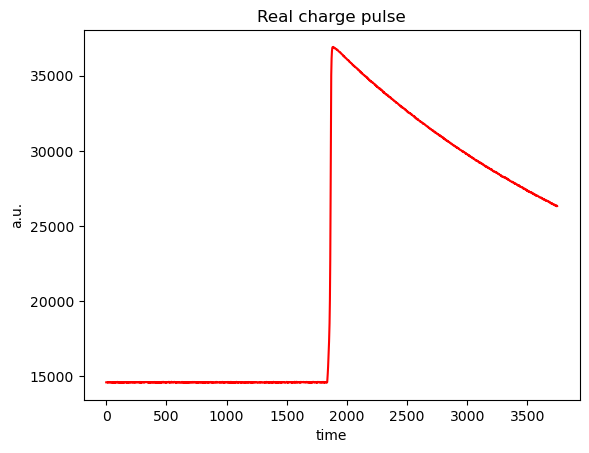

In [12]:
plt.plot(real[0], color = 'red')
plt.title('Real charge pulse')
plt.xlabel('time')
plt.ylabel('a.u.')
# plt.plot(1848, real[0][1848], marker='o', color = 'black')
# plt.plot(1871, real[0][1871], marker='o', color = 'black')
# plt.axhline(real[0][1888], color = 'black', linestyle = '--')

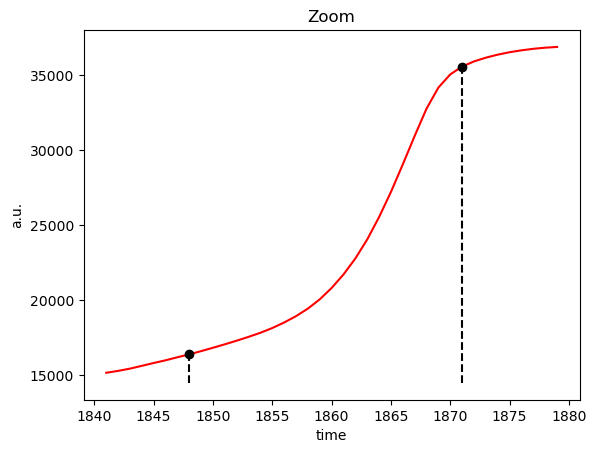

In [13]:
tmp = []
for i in range(real[0].shape[0]):
    if i > 1840 and i < 1880:
        tmp.append(real[0][i])

plt.plot([i for i in range(1841, 1880)],tmp, color = 'red')
plt.plot(1848, real[0][1848], marker='o', color = 'black')
plt.plot(1871, real[0][1871], marker='o', color = 'black')
plt.title('Zoom')
plt.xlabel('time')
plt.ylabel('a.u.')
plt.vlines(1848, ymin = real[0][0] - 100, ymax = real[0][1848], color = 'black', linestyle = '--')
plt.vlines(1871, ymin = real[0][0] - 100, ymax = real[0][1871], color = 'black', linestyle = '--')

Fake data

In [14]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 256
#emb_dim = seq_len // 16
#wgan
hidden_dim = 8
latent_dims = 32 
random_dim = latent_dims

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.latent_dims = latent_dims
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False)
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [16]:
class Discriminator(nn.Module):   ## changed
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.seq_len // 8, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 16, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [17]:
G = Generator()
G.load_state_dict(torch.load( "generator.pth"))

<All keys matched successfully>

In [18]:
noise = torch.randn(50000, latent_dims)

In [19]:
# scaler for inverse transormation of fake data
scaler = StandardScaler()
tmp = scaler.fit_transform(real) 

pca = PCA(n_components=256)
tmp1 = pca.fit_transform(tmp) #!!!


fake = G(noise).detach()
fake = pca.inverse_transform(fake) # back to 3748
fake = scaler.inverse_transform(fake)

Text(0, 0.5, 'a.u.')

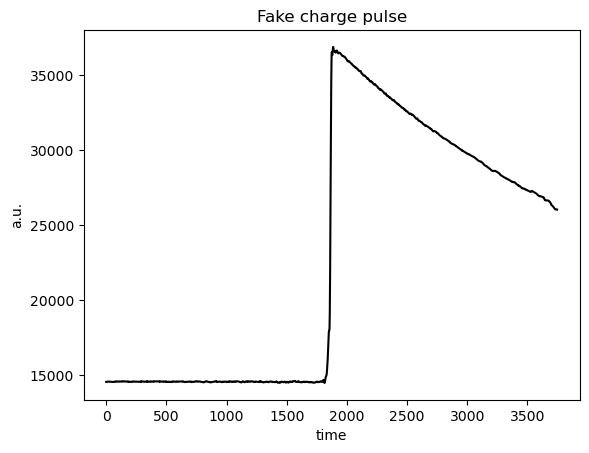

In [20]:
plt.plot(fake[11], color = 'black')
plt.title('Fake charge pulse')
plt.xlabel('time')
plt.ylabel('a.u.')

In [21]:
#  ######postfactum normalisation
# for i in range(fake.shape[0]):
#     fake[i] = (fake[i] - fake[i].min()) / (fake[i].max() - fake[i].min())

Plotting

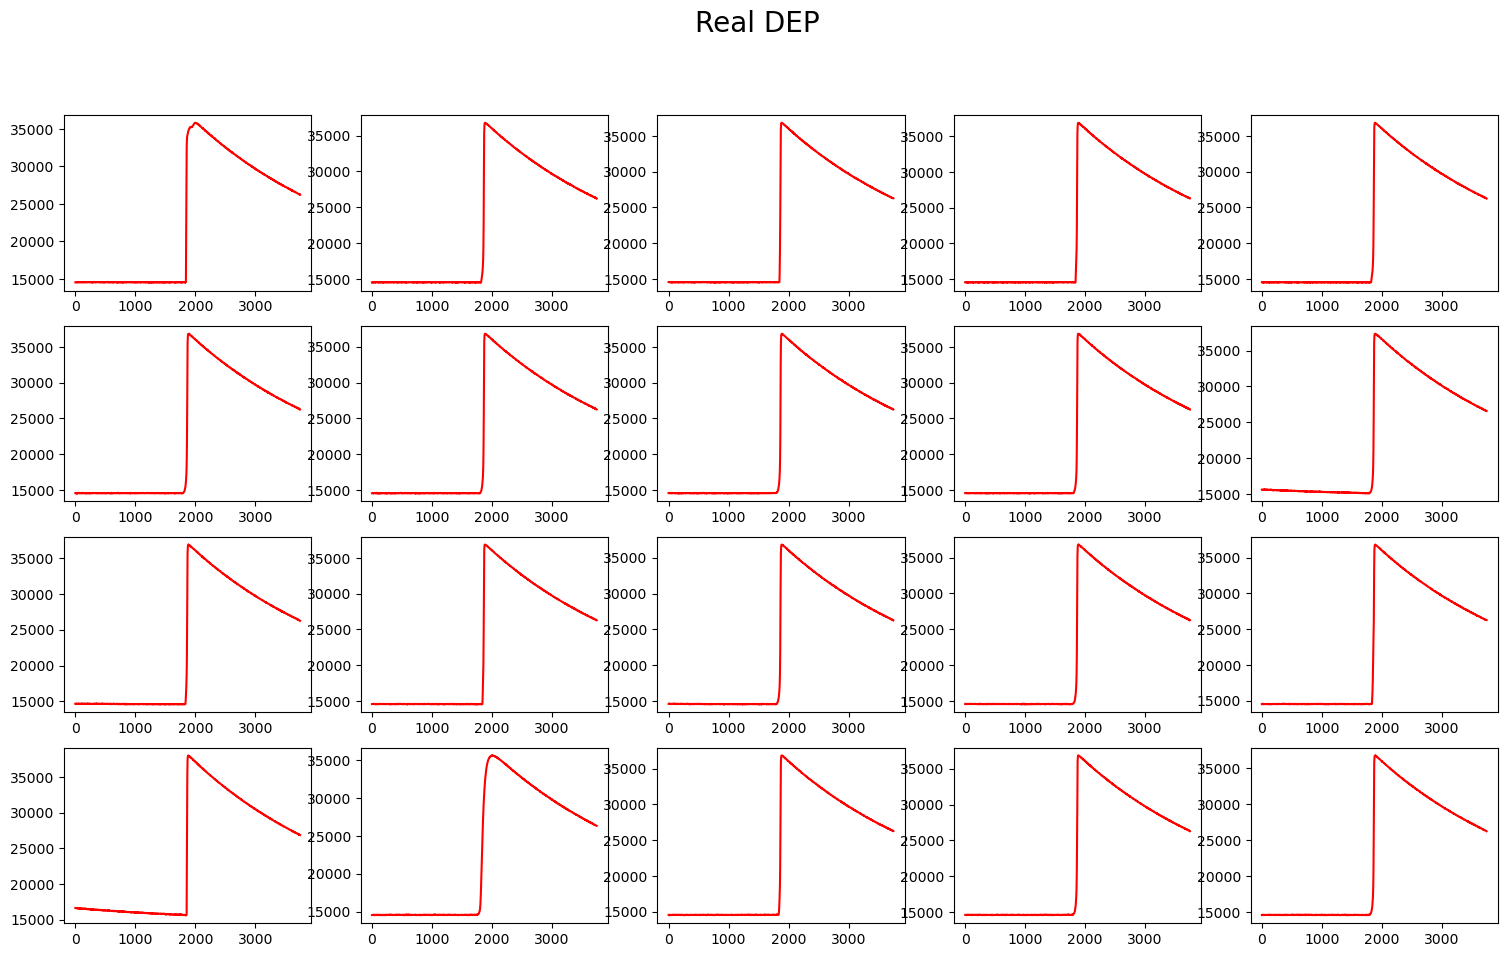

In [22]:
fig, axis = plt.subplots(4, 5, figsize=(18.5, 10.5))

#fig.set_size_inches(18.5, 10.5)
for i in range(4):
    for j in range(5):
        axis[i, j].plot(real[random.randint(0, 15000)], color = 'red')
plt.suptitle('Real DEP',fontsize=20)
fig.savefig('real.png')

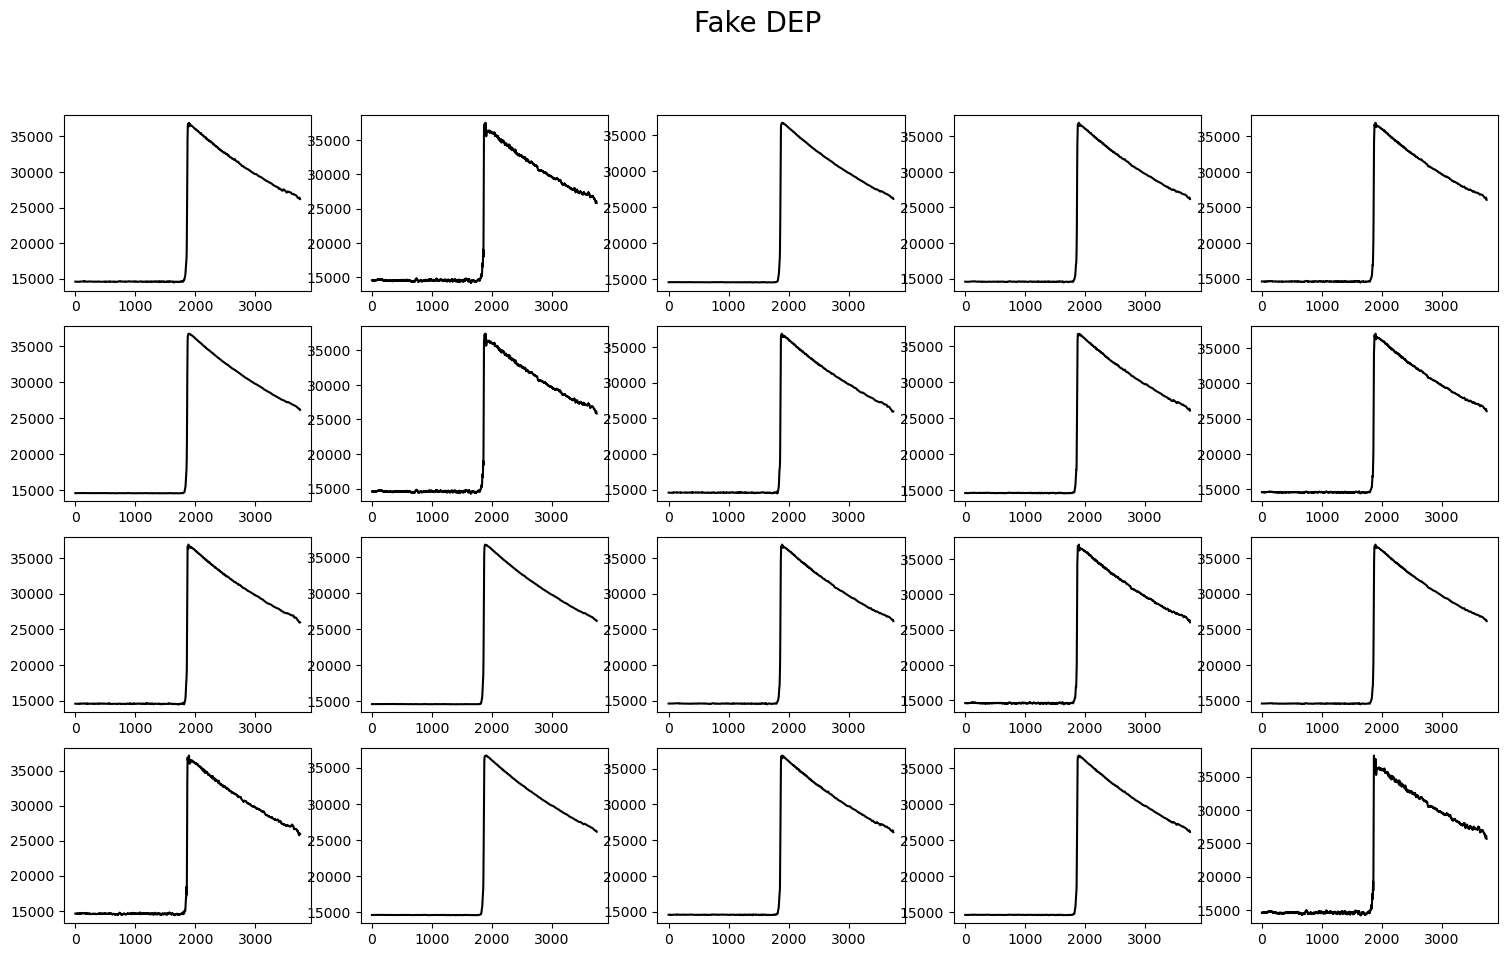

In [23]:
fig, axis = plt.subplots(4, 5, figsize=(18.5, 10.5))

#fig.set_size_inches(18.5, 10.5)
for i in range(4):
    for j in range(5):
        axis[i, j].plot(fake[random.randint(0, 15000)], color = 'black')
plt.suptitle('Fake DEP',fontsize=20)
fig.savefig('fake.png')

## Energy

In [22]:
max_real = []
for i in range(real.shape[0]):
    tmp = np.array(real[i])
    max_real.append(tmp.max() - tmp.min())

In [23]:
max_fake = []
for i in range(fake.shape[0]):
    tmp = np.array(fake[i])
    max_fake.append(tmp.max() - tmp.min())

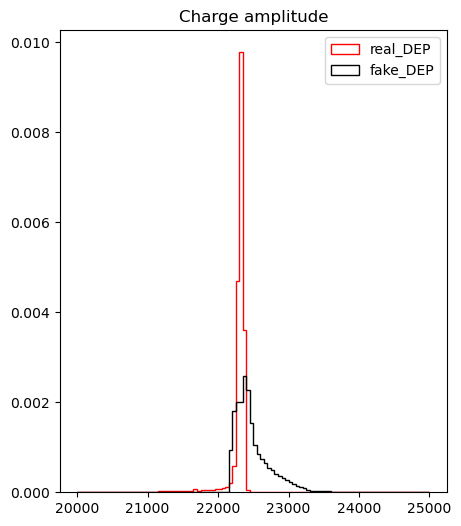

In [25]:
fig = plt.figure(figsize = (5,6))

a1, _, _ = plt.hist(max_real, bins = 100, density = True, range = [20000, 25000], label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake, bins = 100, density = True, range = [20000, 25000], label = 'fake_DEP',histtype = 'step', color = 'black')

plt.legend()
plt.title('Charge amplitude')
plt.show()

fig.savefig('charge.png')

### Energy_cuts

In [27]:
A = pd.DataFrame()

A = ['wf'+str(i) for i in range (3748)]
A = pd.DataFrame(fake, columns = A)

In [28]:
A['en'] = max_fake

In [29]:
B = A[A.en < 22400]
B = B[B.en > 22200]

In [30]:
fake = np.array(B.iloc[:,:-1])
print(fake.shape)

(23442, 3748)


In [31]:
max_fake = []
for i in range(fake.shape[0]):
    tmp = np.array(fake[i])
    max_fake.append(tmp.max() - tmp.min())

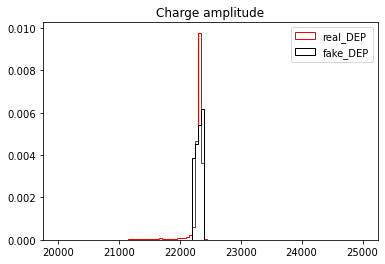

In [32]:
fig = plt.figure()

a1, _, _ = plt.hist(max_real, bins = 100, density = True, range = [20000, 25000], label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake, bins = 100, density = True, range = [20000, 25000], label = 'fake_DEP',histtype = 'step', color = 'black')

plt.legend()
plt.title('Charge amplitude')
plt.show()

fig.savefig('charge.png')

## Current

In [27]:
real_c = []
for i in range(real.shape[0]):
    tmp = []
    for j in range(real.shape[1]-1):
        tmp.append(real[i][j+1] - real[i][j])
    real_c.append(tmp)
    
real_c = np.array(real_c)

max_real_c = []
for i in range(real_c.shape[0]):
    tmp = np.array(real_c[i])
    max_real_c.append(tmp.max() - tmp.min())

1893.0

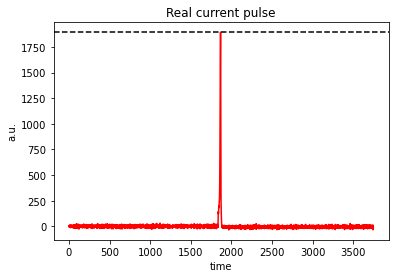

In [28]:
plt.plot(real_c[0], color='red')
plt.title('Real current pulse')
plt.xlabel('time')
plt.ylabel('a.u.')
plt.axhline(real_c[0][1866], color = 'black', linestyle = '--')
real_c[0].max()

In [29]:
fake_c = []
for i in range(fake.shape[0]):
    tmp = []
    for j in range(fake.shape[1]-1):
        tmp.append(fake[i][j+1] - fake[i][j])
    fake_c.append(tmp)
    
fake_c = np.array(fake_c)

max_fake_c = []
for i in range(fake_c.shape[0]):
    tmp = np.array(fake_c[i])
    max_fake_c.append(tmp.max()- tmp.min())

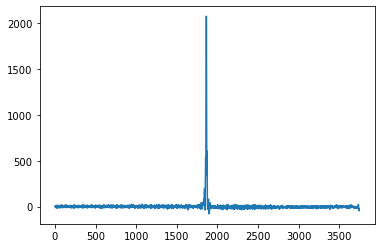

In [30]:
plt.plot(fake_c[8])

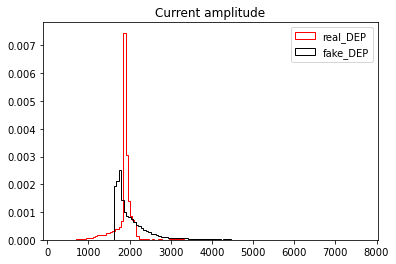

In [31]:
fig = plt.figure()
a1, _, _ = plt.hist(max_real_c, bins = 100,  label = 'real_DEP', density = True, histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake_c, bins = 100,  label = 'fake_DEP', density = True, histtype = 'step', color = 'black')

plt.legend()
plt.title('Current amplitude')
plt.show()
fig.savefig('current.png')

### Current cuts

In [38]:
B # fake after energy cuts

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,en
0,14591.015522,14591.015522,14596.773049,14592.122542,14587.415891,14582.690948,14580.394970,14581.374263,14583.975067,14579.492288,...,26361.673034,26351.123421,26326.096802,26294.132844,26268.799382,26247.095305,26213.936436,26175.186904,26141.005110,22335.440741
1,14578.254976,14578.254976,14586.858906,14581.673352,14574.488341,14569.631396,14563.520454,14559.526442,14562.914220,14561.009491,...,26384.648811,26373.714685,26355.420783,26327.174634,26297.173457,26270.288638,26238.913787,26208.194190,26176.450408,22389.789791
6,14559.743453,14559.743453,14567.264831,14559.983779,14552.328415,14556.752966,14551.125651,14538.155985,14543.711672,14545.015302,...,26204.233101,26186.439781,26164.447258,26132.569589,26091.940283,26048.396864,26009.786926,25983.206216,25945.199351,22386.583182
7,14567.963608,14567.963608,14576.604620,14571.100956,14563.280979,14563.790846,14558.240389,14547.709248,14550.750071,14551.901403,...,26346.332609,26325.535850,26301.121208,26266.789419,26223.493309,26178.320320,26136.039728,26103.888687,26061.994533,22377.451750
8,14597.205736,14597.205736,14602.207186,14597.062323,14593.224429,14587.902050,14586.790957,14589.457656,14593.060590,14587.327208,...,26378.159968,26363.500981,26328.996993,26288.223025,26258.717633,26233.087864,26191.863635,26142.338963,26100.063775,22396.425556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,14592.018159,14592.018159,14596.023162,14592.961293,14589.744516,14587.622443,14586.382033,14585.663932,14586.665984,14584.545349,...,26291.845110,26283.164231,26267.859586,26248.566299,26231.602133,26216.243770,26195.479032,26173.209910,26151.173702,22209.244492
49993,14577.126613,14577.126613,14580.586426,14578.245648,14573.470061,14577.023687,14575.418020,14569.665743,14573.811096,14574.263804,...,26129.716909,26122.940710,26114.520422,26102.648746,26086.749593,26069.173369,26055.107887,26047.965128,26032.953840,22209.700658
49996,14591.609132,14591.609132,14597.604635,14592.582720,14587.513611,14582.471674,14580.239098,14581.124643,14583.929859,14579.317090,...,26381.074582,26369.646170,26343.206383,26309.362999,26282.093698,26258.778739,26224.240430,26183.668500,26147.664594,22356.419116
49998,14586.146653,14586.146653,14593.310098,14588.747821,14582.439472,14577.579441,14574.143685,14573.348833,14576.228443,14572.676786,...,26372.596472,26362.841135,26341.382463,26311.707976,26285.273165,26262.256589,26231.311065,26197.269341,26165.077707,22331.818249


In [39]:
B['cur'] = max_fake_c

In [40]:
C = B[B.cur > 1750]
# C = C[C.cur < 2100]

In [41]:
fake = np.array(C.iloc[:,:-2])
print(fake.shape)

(10270, 3748)


In [42]:
fake_c = []
for i in range(fake.shape[0]):
    tmp = []
    for j in range(fake.shape[1]-1):
        tmp.append(fake[i][j+1] - fake[i][j])
    fake_c.append(tmp)
    
fake_c = np.array(fake_c)

max_fake_c = []
for i in range(fake_c.shape[0]):
    tmp = np.array(fake_c[i])
    max_fake_c.append(tmp.max()- tmp.min())

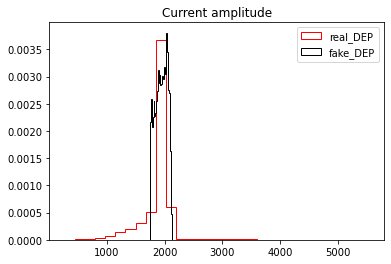

In [43]:
fig = plt.figure()
a1, _, _ = plt.hist(max_real_c, bins = 30,  label = 'real_DEP', density = True, histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake_c, bins = 30,  label = 'fake_DEP', density = True, histtype = 'step', color = 'black')

plt.legend()
plt.title('Current amplitude')
plt.show()
fig.savefig('current.png')

## Tail slope

In [32]:
for i in range(real.shape[0]):
    real[i] = (real[i] - real[i].min()) / (real[i].max() - real[i].min())
    
for i in range(fake.shape[0]):
    fake[i] = (fake[i] - fake[i].min()) / (fake[i].max() - fake[i].min())

In [33]:
def slope(mas):
    p97 = []
    for i in range(mas.shape[0]):
        for j in range(1800, 1888):
            if abs(mas[i][j] - 0.97) <= 0.1:
                p97.append(j)
                break
            else:
                p97.append(1874)
                break
    p97 = np.array(p97) # shape==i
    
    avs = []
    for i in range(mas.shape[0]):
        sum1 = 0
        for j in range(p97[i] + 200,p97[i] + 300):
            sum1 = sum1 + mas[i][j]
        avs.append(sum1 / 100)        
    avs = np.array(avs)
    #print(avs)
    
    avs2 = []
    for i in range(mas.shape[0]):
        sum2 = 0
        for j in range(mas.shape[1] - 100, mas.shape[1]):
            sum2 = sum2 + mas[i][j]
        avs2.append(sum2 / 100)
    avs2 = np.array(avs2)
    #print(avs2)
    
    
    slop = []
    for i in range(mas.shape[0]):
        distance = (mas.shape[1] - 50) - (p97[i] + 250)
        #print(distance)
        tmp = abs(avs2[i] - avs[i]) / distance
        slop.append(tmp)
    return np.array(slop)

In [34]:
sl_r = slope(real) * 10**4
sl_f = slope(fake) * 10**4

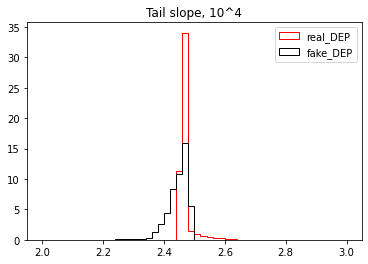

In [35]:
fig = plt.figure()
a1, _, _ = plt.hist(sl_r, bins = 50, density = True, range = [2, 3],label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(sl_f, bins = 50, density = True, range = [2, 3],label = 'fake_DEP',histtype = 'step', color = 'black')

plt.title('Tail slope, 10^4')
plt.legend()
plt.show()
fig.savefig('slope.png')

## Drift time

In [36]:
def drift(mas):
    drifttimes = []
    for j in range(mas.shape[0]):
        for i in range(1888):
            if (mas[j][i] - 0.9 <= 0.05):
                k90 = i
            if  mas[j][i] - 0.1 <= 0.05:
                k10 = i
        drifttimes.append(k90 - k10)
        #print(k10, k90)
    drifttimes = np.array(drifttimes)
    return drifttimes

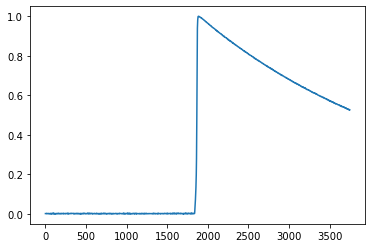

In [37]:
plt.plot(real[0])

In [38]:
# for i in range(real.shape[0]):
#     real[i] = (real[i] - real[i].min()) / (real[i].max() - real[i].min())
    
# for i in range(fake.shape[0]):
#     fake[i] = (fake[i] - fake[i].min()) / (fake[i].max() - fake[i].min())
    

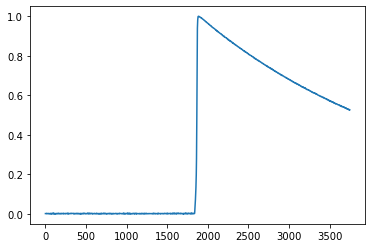

In [39]:
plt.plot(real[0])

In [40]:
rr = drift(real)
rf = drift(fake)

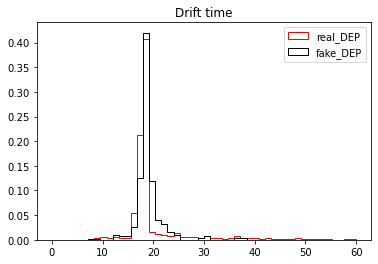

In [41]:
fig = plt.figure()
a1, _, _ = plt.hist(rr, bins = 50, density = True,range=[0,60],  label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(rf, bins = 50, density = True, range=[0,60], label = 'fake_DEP',histtype = 'step', color = 'black')

plt.legend()
plt.title('Drift time')
plt.show()
fig.savefig('drifttime.png')

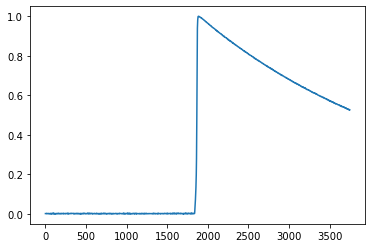

In [57]:
plt.plot(real[0])

## Classification

In [97]:
wflist_dep = wflist(filename_dep)
dep = wf_dataframe(wflist_dep)
dep['label'] = 1

In [98]:
dep = shuffle(dep)
dep = dep.reset_index(drop=True)

In [99]:
dep = dep.iloc[:10270, :]
dep.drop('avse', inplace = True, axis = 1)
dep.drop('tDrift', inplace = True, axis = 1)
dep.drop('t0', inplace = True, axis = 1)

In [100]:
D = C.copy()
D = D.iloc[:, :-2]
D['label'] = 0

In [101]:
D

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,label
0,14591.015522,14591.015522,14596.773049,14592.122542,14587.415891,14582.690948,14580.394970,14581.374263,14583.975067,14579.492288,...,26361.673034,26351.123421,26326.096802,26294.132844,26268.799382,26247.095305,26213.936436,26175.186904,26141.005110,0
1,14578.254976,14578.254976,14586.858906,14581.673352,14574.488341,14569.631396,14563.520454,14559.526442,14562.914220,14561.009491,...,26384.648811,26373.714685,26355.420783,26327.174634,26297.173457,26270.288638,26238.913787,26208.194190,26176.450408,0
8,14597.205736,14597.205736,14602.207186,14597.062323,14593.224429,14587.902050,14586.790957,14589.457656,14593.060590,14587.327208,...,26378.159968,26363.500981,26328.996993,26288.223025,26258.717633,26233.087864,26191.863635,26142.338963,26100.063775,0
9,14589.555402,14589.555402,14596.427112,14591.243423,14585.284798,14579.738630,14576.752193,14577.117096,14580.551064,14576.304288,...,26393.981543,26382.412877,26357.064644,26323.410506,26294.519359,26269.833741,26235.207934,26195.375450,26159.130723,0
10,14589.944799,14589.944799,14592.361851,14597.859181,14599.271969,14597.130791,14596.620959,14597.915536,14603.824134,14604.420386,...,26091.653366,26088.873376,26086.344443,26078.630635,26070.899372,26062.196683,26050.198488,26040.885375,26031.060423,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49982,14591.448822,14591.448822,14596.248815,14592.468342,14588.429673,14585.505406,14583.986372,14583.468204,14584.758589,14581.946287,...,26310.210190,26301.582347,26284.215062,26261.967811,26243.031800,26226.561017,26203.222019,26177.365647,26152.538096,0
49987,14580.179099,14580.179099,14588.045752,14583.579365,14576.741718,14572.299173,14567.164480,14563.801516,14566.764254,14564.703935,...,26379.233960,26367.949016,26348.774174,26320.336905,26291.037286,26264.208210,26232.743307,26201.707099,26169.800391,0
49989,14592.018159,14592.018159,14596.023162,14592.961293,14589.744516,14587.622443,14586.382033,14585.663932,14586.665984,14584.545349,...,26291.845110,26283.164231,26267.859586,26248.566299,26231.602133,26216.243770,26195.479032,26173.209910,26151.173702,0
49996,14591.609132,14591.609132,14597.604635,14592.582720,14587.513611,14582.471674,14580.239098,14581.124643,14583.929859,14579.317090,...,26381.074582,26369.646170,26343.206383,26309.362999,26282.093698,26258.778739,26224.240430,26183.668500,26147.664594,0


In [103]:
dep

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,label
0,14556,14556,14551,14562,14573,14563,14565,14550,14549,14565,...,26254,26263,26276,26287,26278,26263,26261,26261,26254,1
1,14586,14586,14579,14580,14587,14593,14593,14595,14594,14598,...,26314,26302,26302,26297,26285,26293,26309,26314,26303,1
2,14515,14515,14521,14542,14545,14547,14540,14553,14568,14583,...,26267,26271,26269,26258,26251,26254,26254,26255,26255,1
3,14574,14574,14560,14561,14558,14562,14567,14563,14567,14565,...,26342,26340,26336,26316,26294,26283,26286,26284,26294,1
4,14537,14537,14538,14548,14563,14559,14560,14558,14567,14564,...,26250,26258,26262,26261,26246,26255,26267,26268,26241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10265,14598,14598,14590,14584,14584,14579,14566,14561,14556,14564,...,26290,26284,26282,26270,26255,26249,26259,26268,26259,1
10266,14553,14553,14555,14560,14557,14569,14551,14539,14537,14535,...,26306,26282,26274,26267,26276,26273,26268,26265,26257,1
10267,14548,14548,14551,14545,14554,14545,14534,14534,14546,14547,...,26282,26283,26281,26273,26278,26288,26290,26287,26278,1
10268,14571,14571,14575,14583,14583,14603,14618,14619,14611,14591,...,26301,26294,26299,26302,26296,26287,26276,26268,26274,1


In [104]:
data = pd.concat([dep, D])

In [107]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,label
0,14556.000000,14556.000000,14551.000000,14562.000000,14573.000000,14563.000000,14565.000000,14550.000000,14549.000000,14565.000000,...,26254.000000,26263.000000,26276.000000,26287.000000,26278.000000,26263.000000,26261.000000,26261.000000,26254.000000,1
1,14586.000000,14586.000000,14579.000000,14580.000000,14587.000000,14593.000000,14593.000000,14595.000000,14594.000000,14598.000000,...,26314.000000,26302.000000,26302.000000,26297.000000,26285.000000,26293.000000,26309.000000,26314.000000,26303.000000,1
2,14515.000000,14515.000000,14521.000000,14542.000000,14545.000000,14547.000000,14540.000000,14553.000000,14568.000000,14583.000000,...,26267.000000,26271.000000,26269.000000,26258.000000,26251.000000,26254.000000,26254.000000,26255.000000,26255.000000,1
3,14574.000000,14574.000000,14560.000000,14561.000000,14558.000000,14562.000000,14567.000000,14563.000000,14567.000000,14565.000000,...,26342.000000,26340.000000,26336.000000,26316.000000,26294.000000,26283.000000,26286.000000,26284.000000,26294.000000,1
4,14537.000000,14537.000000,14538.000000,14548.000000,14563.000000,14559.000000,14560.000000,14558.000000,14567.000000,14564.000000,...,26250.000000,26258.000000,26262.000000,26261.000000,26246.000000,26255.000000,26267.000000,26268.000000,26241.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49982,14591.448822,14591.448822,14596.248815,14592.468342,14588.429673,14585.505406,14583.986372,14583.468204,14584.758589,14581.946287,...,26310.210190,26301.582347,26284.215062,26261.967811,26243.031800,26226.561017,26203.222019,26177.365647,26152.538096,0
49987,14580.179099,14580.179099,14588.045752,14583.579365,14576.741718,14572.299173,14567.164480,14563.801516,14566.764254,14564.703935,...,26379.233960,26367.949016,26348.774174,26320.336905,26291.037286,26264.208210,26232.743307,26201.707099,26169.800391,0
49989,14592.018159,14592.018159,14596.023162,14592.961293,14589.744516,14587.622443,14586.382033,14585.663932,14586.665984,14584.545349,...,26291.845110,26283.164231,26267.859586,26248.566299,26231.602133,26216.243770,26195.479032,26173.209910,26151.173702,0
49996,14591.609132,14591.609132,14597.604635,14592.582720,14587.513611,14582.471674,14580.239098,14581.124643,14583.929859,14579.317090,...,26381.074582,26369.646170,26343.206383,26309.362999,26282.093698,26258.778739,26224.240430,26183.668500,26147.664594,0


In [108]:
data = data.reset_index(drop=True)

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [121]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data.iloc[:,0:-1],data.iloc[:,-1],test_size=0.3, random_state=1)

In [122]:
xgbc = KNeighborsClassifier(n_neighbors=3)

In [123]:
xgbc.fit(train_X, train_Y)

KNeighborsClassifier(n_neighbors=3)

In [124]:
ypred = xgbc.predict_proba(test_X)

In [125]:
fpr, tpr, thresholds = metrics.roc_curve(test_Y, ypred[:, 1])

In [126]:
thrs = 0.5

In [127]:
ypred2 = (ypred[:, 1]>=thrs)

In [128]:
print ('accuracy = ' + str(metrics.accuracy_score(test_Y, ypred2)))

accuracy = 1.0


roc_auc = 1.0


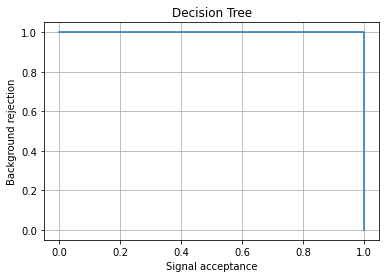

In [129]:
plt.plot( tpr,  np.abs(1-fpr))
plt.xlabel('Signal acceptance')
plt.ylabel('Background rejection')
plt.title('Decision Tree')
plt.grid()
#plt.legend()
print('roc_auc = '+ str(metrics.roc_auc_score(test_Y, ypred2)))

Text(0.5, 1.0, 'Decision Tree')

<Figure size 2880x2160 with 0 Axes>

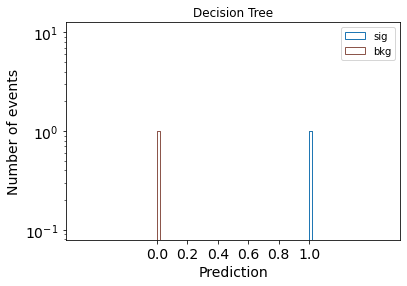

In [130]:
A = np.array(ypred[:,1])
idx_sig = np.where(test_Y == 1)[0] #signal
idx_bkg = np.where(test_Y == 0)[0]# выдает номера 


# Histogram predictions without error bars: #количес
bins = 50
fig14 = plt.figure(figsize=(40,30))
fig14, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(A[[idx_sig]], histtype='step', label='sig', bins = bins)
n2, bins2, patches2 = ax.hist(A[[idx_bkg]], histtype='step', label='bkg', bins = bins)
ax.set_xlabel('Prediction', {'fontsize': 14})
ax.set_ylabel('Number of events', {'fontsize': 14})
plt.yticks((10**0, 10**1, 10**2, 10**3), color='k', size=14)
plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
plt.yscale('log')
plt.legend(loc="upper right")
#fig14.savefig("predictions.pdf", bbox_inches='tight')
plt.title('Decision Tree')